In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import math
import torch.nn.functional as F

import sys
sys.path.append('..')
from utils.metrics import AndersonDarlingDistance, KendallDependenceMetric

from sklearn.preprocessing import StandardScaler

Tensor = torch.Tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
'''
Load Dataset
'''
data = pd.read_csv('../data_train_log_return.csv', header=None).drop(columns=[0])
scaler = StandardScaler().fit(data.values)
X_train = torch.Tensor(scaler.transform(data.values)).to(device)
data = torch.Tensor(data.values).to(device)

'''
Load Metrics
'''
ad = AndersonDarlingDistance()
kd = KendallDependenceMetric()

def compute_metrics(batch):
    size = batch.size(0)
    device_ = batch.device
    _,x = model.sample(size,device_)
    anderson = ad(batch.clone().detach(), x.clone().detach())
    kendall  = kd(batch.clone().detach(), x.clone().detach())
    return anderson, kendall

def visual_3D(data):
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    color = data[:,3]  # 4th dimension
    
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(x, y, z, c=color, cmap='viridis')
    
    plt.colorbar(scatter)
    ax.set_xlabel('1st Dimension')
    ax.set_ylabel('2nd Dimension')
    ax.set_zlabel('3rd Dimension')
    plt.show()

### Diffusion Model

In [4]:
class DiffusionModel:
    def __init__(self, model, n_steps, beta_1, beta_t, device):
        """
        Denoising Diffusion Probabilistic Model diffusion model
        Personnal light implementation according to https://arxiv.org/pdf/2006.11239.pdf
        :param torch.nn.Module: model used to predict noise of diffused images
        :param int n_steps: total number of diffusion steps
        :param float beta_1: initial beta for beta scheduler
        :param float beta_t: last beta for beta scheduler
        :param string device: torch device to place tensors and model on
        """
        self.model = model.to(device)
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_1, beta_t, self.n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, axis=0)

        self.r_alphas_bar = torch.sqrt(self.alphas_bar)
        self.r_1m_alphas_bar = torch.sqrt(1 - self.alphas_bar)

        self.inv_r_alphas = torch.pow(self.alphas, -0.5)
        self.pre_noise_terms = self.betas / self.r_1m_alphas_bar
        self.sigmas = torch.pow(self.betas, 0.5)

        self.device = device

    def diffuse(self, x, t):
        """
        Diffuse x for t steps.
        :param torch.Tensor x: 2d data points to diffuse
        :param torch.Tensor t: number of diffusion time steps
        :return: diffused data points
        """
        eps = torch.randn(x.shape).to(self.device)
        t = t - 1
        diffused = self.r_alphas_bar[t] * x + self.r_1m_alphas_bar[t] * eps
        return eps, diffused

    def denoise(self, x, t):
        """
        Denoise random samples x for t steps.
        :param torch.Tensor x: initial 2d data points to denoise
        :param torch.Tensor t: number of denoising time steps
        :return torch.tensor, list: (denoised data points, list of each denoised data points for all diffusion steps)
        """
        n_samples = 1
        if len(x.shape)>1:
            n_samples = x.shape[0]
        all_x = [x]
        for i in range(t, 0, -1):
            z = torch.randn(x.shape).to(self.device)
            if i == 1:
                z = z * 0
            steps = torch.full((n_samples,), i, dtype=torch.int, device=self.device).unsqueeze(1)
            model_output = self.model(x, steps)
            x = self.inv_r_alphas[i - 1] * (x - self.pre_noise_terms[i - 1] * model_output) + self.sigmas[i - 1] * z
            all_x.append(x)
        return x, all_x


class NoiseModel(nn.Module):
    def __init__(self, n_steps):
        super(NoiseModel, self).__init__()
        self.n_steps = n_steps
        w = 64
        t_w = 1
        self.t_layer = nn.Sequential(nn.Linear(1, t_w),
                                  nn.ReLU(),
                                  nn.Linear(t_w, t_w),
                                  nn.ReLU())
        
        self.layer1 = nn.Sequential(nn.Linear(t_w + 4, w),
                                    nn.ReLU(),
                                    nn.Linear(w, w),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(w, w),
                                    nn.ReLU(),
                                    nn.Linear(w, w),
                                    nn.ReLU(),
                                   )
        self.layer3 = nn.Sequential(nn.Linear(w + t_w, w),
                                    nn.ReLU(),
                                    nn.Linear(w, w),
                                    nn.Tanh())

        self.last_layer = nn.Linear(w, 4)

    def forward(self, x, t):
        t = (t.float() / self.n_steps) - 0.5
        temb = self.t_layer(t)

        output = self.layer1(torch.concat([x, temb], axis=-1))
        output = self.layer2(output)
        output = self.layer3(torch.concat([output, temb], axis=-1))
        return self.last_layer(output)

class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

def train(data,  beta_1, beta_t, batch_size, n_epochs, n_steps, lr, device):
    my_dataset = TensorDataset(torch.Tensor(data))
    my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    model = NoiseModel(n_steps)
    diffuser = DiffusionModel(model, n_steps, beta_1, beta_t, device)

    ema = EMA(0.9)
    ema.register(diffuser.model)

    optimizer = torch.optim.Adam(diffuser.model.parameters(), lr=lr, weight_decay=0.001)

    diffuser.model.train()
    all_losses = []

    for epoch in tqdm(range(n_epochs)):
        for batch in my_dataloader:
            batch = batch[0].to(device)
            t = torch.randint(1, diffuser.n_steps + 1, (len(batch),)).unsqueeze(1).to(device)
            eps, diffused = diffuser.diffuse(batch, t)
            pred_eps = model(diffused, t)

            loss = (eps - pred_eps) ** 2
            loss = loss.mean()

            optimizer.zero_grad()
            loss.backward()
            loss = loss.detach().item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()
            ema.update(model)
            all_losses.append(loss)
    
    ema.ema(model)
    return diffuser, all_losses

/Data/.sys/envs/env0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████| 500/500 [00:03<00:00, 126.85it/s]


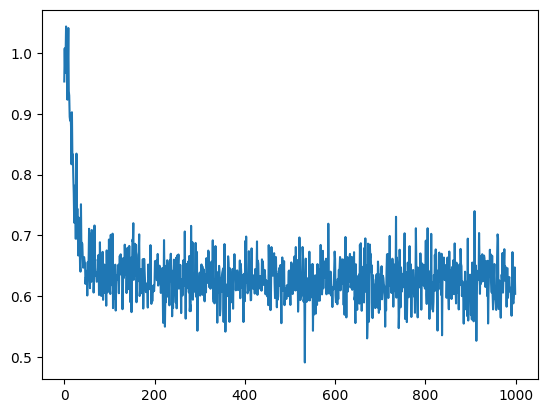

In [5]:
batch_size = 512
n_epochs = 500
n_steps = 100
lr = 0.003
beta_1 = 0.0001
beta_t = 0.02

diffuser, all_losses = train(X_train, beta_1, beta_t, batch_size, n_epochs, n_steps, lr, device)
plt.plot(all_losses)

In [6]:
#eval_data = (torch.rand(512,2)-0.5) * 2
eval_data = torch.randn(len(X_train),4)

diffuser.model.eval()
with torch.no_grad():
    batch = torch.Tensor(eval_data)
    sample, all_samples = diffuser.denoise(torch.Tensor(eval_data).to(device), n_steps)

print(f'Anderson Darling Distance: {float(ad.forward(X_train, sample)):.4f} \
        \nKendall Dependence: {float(kd.forward(X_train, sample)):.4f}')

sample = scaler.inverse_transform(sample.detach().cpu().numpy())
sample = Tensor(sample).to(device)

print(f'Anderson Darling Distance: {float(ad.forward(data, sample)):.4f} \
        \nKendall Dependence: {float(kd.forward(data, sample)):.4f}')

Anderson Darling Distance: 7.2431         
Kendall Dependence: 0.0125
Anderson Darling Distance: 7.2431         
Kendall Dependence: 0.0125


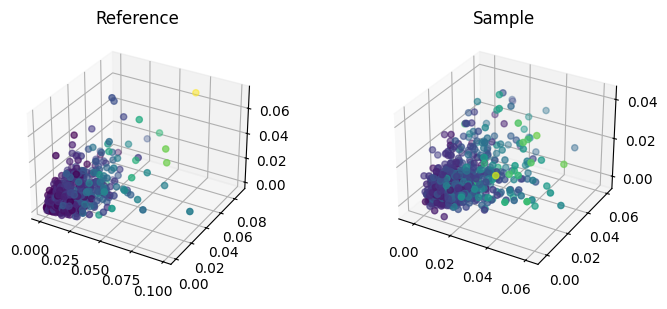

In [7]:
sample = sample.detach().cpu().numpy()
data = data.detach().cpu().numpy()

fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 3]) 
ax.set_title(f'Reference')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], c=sample[:, 3]) 
ax.set_title(f'Sample')

plt.tight_layout()
plt.show()

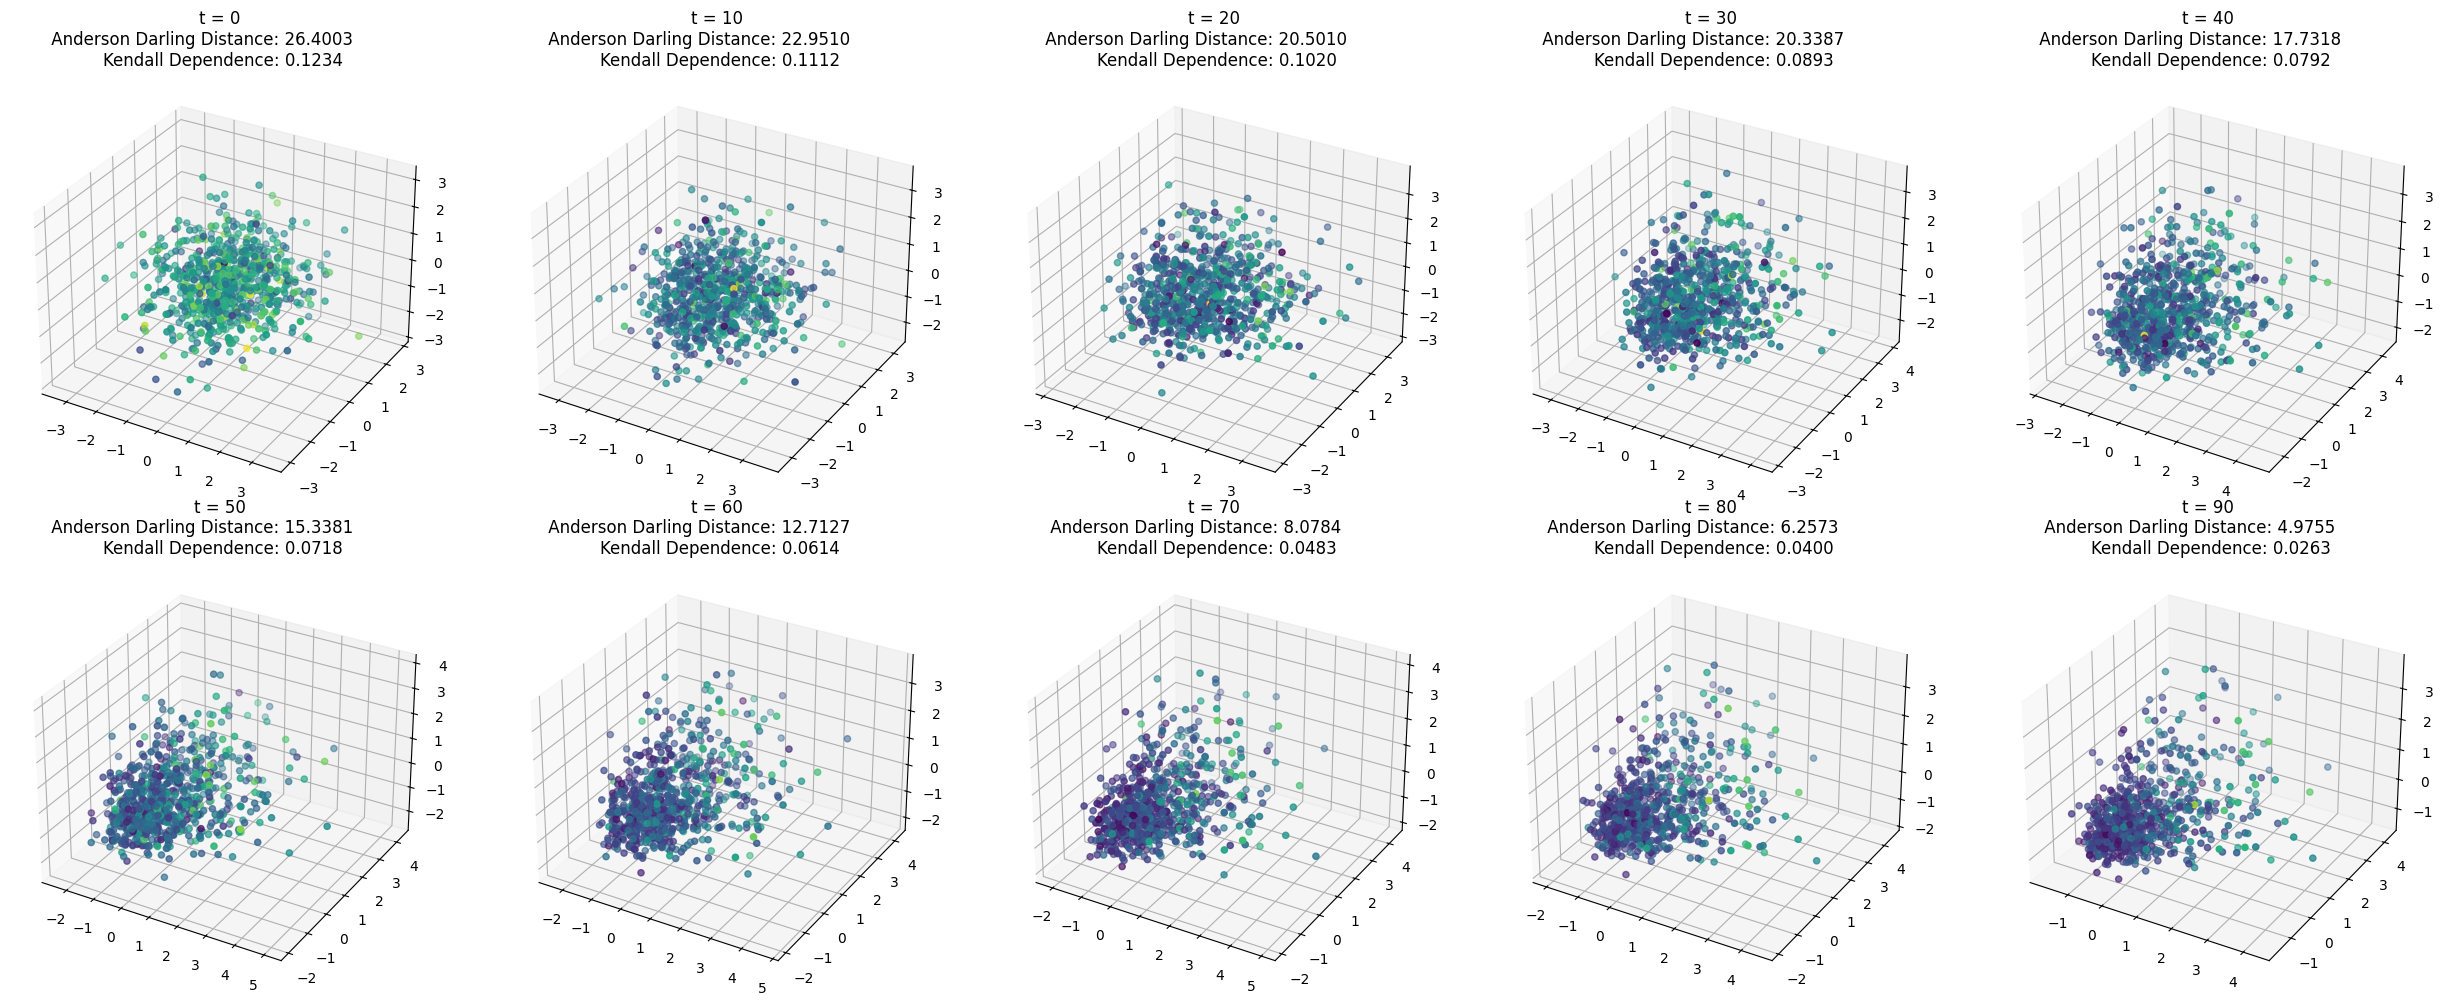

In [8]:
'''
Inverse Process
'''
sample_plot = np.array([all_samples[i].detach().cpu().numpy() for i in range(0, len(all_samples), 10)])

fig = plt.figure(figsize=(25, 10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, projection='3d')  # 2行5列，当前子图位置是i+1
    ax.scatter(sample_plot[i, :, 0], sample_plot[i, :, 1], sample_plot[i, :, 2], c=sample_plot[i, :, 3])  # c为颜色映射
    ax.set_title(f't = {i*10} \n Anderson Darling Distance: {float(ad.forward(Tensor(sample_plot[i]).to(device), X_train)):.4f} \
        \nKendall Dependence: {float(kd.forward(Tensor(sample_plot[i]).to(device), X_train)):.4f}')

plt.tight_layout()
plt.show()


In [9]:
torch.save(diffuser, 'diffusion.pt')

### Inference

In [10]:
diffuser = torch.load('diffusion.pt')

test_data = torch.randn(410,4)

diffuser.model.eval()
with torch.no_grad():
    batch = torch.Tensor(test_data)
    sample, all_samples = diffuser.denoise(torch.Tensor(test_data).to(device), n_steps)

df = pd.DataFrame(sample.cpu().numpy())
df.to_csv('test_set_diffusion', header=None)